<a href="https://colab.research.google.com/github/dinurisenara/Colabra/blob/main/TheramindSA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Required Libraries
Check & Use GPU (Important!)

In [1]:
!pip install transformers datasets torch evaluate scikit-learn pandas matplotlib

import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, Trainer, TrainingArguments
from datasets import load_dataset
import evaluate  # Replaces load_metric
from torch.utils.data import DataLoader
import numpy as np
import shutil
from google.colab import files

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

Mount the google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load pretrained BERT model and Tokenizer

In [3]:
MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3).to(device)  # 3 classes (Positive, Negative, Neutral)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Upload your Kagle API key to colab

In [4]:
from google.colab import files

# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dinurisenara2","key":"94bfc9ffdb950b1b4bb3f85e3c2cedc1"}'}

Move the API key to the current location

In [5]:
import os

# Make the kaggle directory
!mkdir -p ~/.kaggle

# Move kaggle.json to the correct location
!mv kaggle.json ~/.kaggle/

# Set permissions
!chmod 600 ~/.kaggle/kaggle.json

Download the sentiment and emotion analysis dataset

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kushagra3204/sentiment-and-emotion-analysis-dataset")

print("Path to dataset files:", path)

100%|██████████| 14.9M/14.9M [00:01<00:00, 8.43MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kushagra3204/sentiment-and-emotion-analysis-dataset/versions/1


Locate the dowloaded dataset and check the files inside downloaded folder

In [7]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/kushagra3204/sentiment-and-emotion-analysis-dataset/versions/1"

# List all files in the dataset folder
os.listdir(dataset_path)

['archive']

Check files inside the archive folder

In [8]:
import os

# Define the path to the archive folder
archive_path = f"{dataset_path}/archive"

# List the files inside the archive folder
os.listdir(archive_path)

['combined_emotion.csv', 'combined_sentiment_data.csv']

Load and EXplore the csv file.

In [9]:
import pandas as pd

# Define file paths
sentiment_csv = f"{archive_path}/combined_sentiment_data.csv"
emotion_csv = f"{archive_path}/combined_emotion.csv"  # Optional, for later use

# Load Sentiment Dataset
df_sentiment = pd.read_csv(sentiment_csv)

# Show first few rows
df_sentiment.head()

,sentence,sentiment
0,So there is no way for me to plug it in here i...,negative
1,"Good case, Excellent value.",positive
2,Great for the jawbone.,positive
3,Tied to charger for conversations lasting more...,negative
4,The mic is great.,positive


Load emotion data

In [10]:
df_emotion = pd.read_csv(emotion_csv)
df_emotion.head()

,sentence,emotion
0,i just feel really helpless and heavy hearted,fear
1,ive enjoyed being able to slouch about relax a...,sad
2,i gave up my internship with the dmrg and am f...,fear
3,i dont know i feel so lost,sad
4,i am a kindergarten teacher and i am thoroughl...,fear


Explore the Dataset Check Basic Info

In [11]:
df_sentiment.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3309 entries, 0 to 3308
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence   3309 non-null   object
 1   sentiment  3309 non-null   object
dtypes: object(2)
memory usage: 51.8+ KB


Check for missing values

In [12]:
df_sentiment.isnull().sum()

,0
sentence,0
sentiment,0


Check column names

In [13]:
df_sentiment.columns

Index(['sentence', 'sentiment'], dtype='object')

vizualisation of sentiment distribution

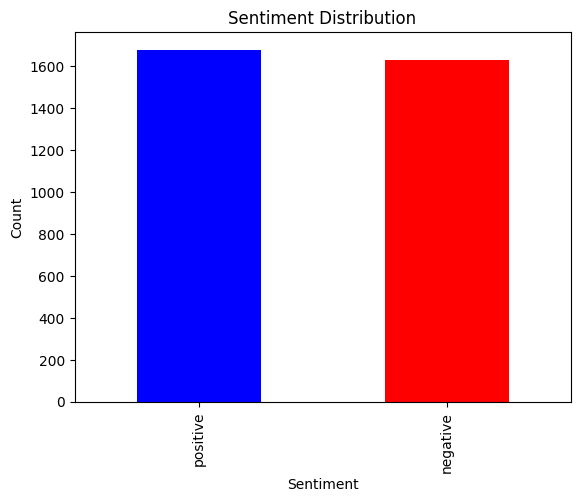

In [14]:
import matplotlib.pyplot as plt

# Plot sentiment distribution
df_sentiment['sentiment'].value_counts().plot(kind='bar', title="Sentiment Distribution", color=['blue', 'red'])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

Text cleaning and pre processing

In [15]:
import re

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.strip()  # Remove extra spaces
    return text

# Apply cleaning function
df_sentiment['cleaned_sentence'] = df_sentiment['sentence'].apply(clean_text)

# Show cleaned data
df_sentiment[['sentence', 'cleaned_sentence']].head()

,sentence,cleaned_sentence
0,So there is no way for me to plug it in here i...,so there is no way for me to plug it in here i...
1,"Good case, Excellent value.",good case excellent value
2,Great for the jawbone.,great for the jawbone
3,Tied to charger for conversations lasting more...,tied to charger for conversations lasting more...
4,The mic is great.,the mic is great


Convert Sentiment into numeric labls

In [16]:
label_mapping = {'negative': 0, 'positive': 1}

# Map sentiment to numeric values
df_sentiment['label'] = df_sentiment['sentiment'].map(label_mapping)

# Check mapping
df_sentiment[['sentiment', 'label']].head()

,sentiment,label
0,negative,0
1,positive,1
2,positive,1
3,negative,0
4,positive,1


Train test split

In [17]:
from sklearn.model_selection import train_test_split

# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_sentiment['cleaned_sentence'], df_sentiment['label'], test_size=0.2, random_state=42
)

# Show sizes
print(f"Training Samples: {len(train_texts)}")
print(f"Testing Samples: {len(test_texts)}")

Training Samples: 2647
Testing Samples: 662


Import BERT tokenizer

In [18]:
from transformers import BertTokenizer

# Load the BERT tokenizer (using 'bert-base-uncased' model)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Apply tokenization to the Dataset

In [19]:
# Tokenize the dataset
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

Convert Dataset into Hugging Face Dataset Format

In [20]:
from datasets import Dataset

# Convert tokenized data to Hugging Face Dataset format
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": list(train_labels)  # Ensure labels are in list format
})

test_dataset = Dataset.from_dict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"],
    "labels": list(test_labels)
})

**Fine. Tuning BERT for Sentiment classification**

In [21]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, AdamW

# Load Pretrained BERT Model with Increased Dropout
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    hidden_dropout_prob=0.3,  # Default is 0.1, increasing to prevent overfitting
    attention_probs_dropout_prob=0.3
).to(device)

# Define Optimizer with Weight Decay
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)  # Lower learning rate & apply weight decay

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./bert_sentiment_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,  # Lower learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,  # Reduced from 3 to 2
    weight_decay=0.01,  # Prevents overfitting
    logging_dir="./logs",
    logging_steps=100,
    load_best_model_at_end=True,  # Automatically load the best checkpoint
    metric_for_best_model="loss",  # Select best model based on validation loss
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    optimizers=(optimizer, None),  # Using our optimizer
)

trainer.train()

<ipython-input-22-32180e351734>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dinurisenara425 (dinurisenara425-staffordshire-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.683800,0.374198
2,0.396100,0.299372


TrainOutput(global_step=332, training_loss=0.5162317063435015, metrics={'train_runtime': 154.1254, 'train_samples_per_second': 34.349, 'train_steps_per_second': 2.154, 'total_flos': 236685866514840.0, 'train_loss': 0.5162317063435015, 'epoch': 2.0})

In [23]:
trainer.evaluate()


{'eval_loss': 0.2993718385696411,
 'eval_runtime': 3.9892,
 'eval_samples_per_second': 165.947,
 'eval_steps_per_second': 10.528,
 'epoch': 2.0}

In [30]:
import numpy as np

# Get true labels from the test dataset
true_labels = test_labels.to_numpy()

# Get model predictions
predictions = trainer.predict(test_dataset)

# Convert logits to class labels
predicted_labels = np.argmax(predictions.predictions, axis=1)

from sklearn.metrics import classification_report

# Print classification report
print(classification_report(true_labels, predicted_labels, target_names=['negative', 'positive']))



              precision    recall  f1-score   support

    negative       0.90      0.91      0.90       334
    positive       0.90      0.89      0.90       328

    accuracy                           0.90       662
   macro avg       0.90      0.90      0.90       662
weighted avg       0.90      0.90      0.90       662



In [25]:
model.save_pretrained("./bert_sentiment_model")
tokenizer.save_pretrained("./bert_sentiment_model")


('./bert_sentiment_model/tokenizer_config.json',
 './bert_sentiment_model/special_tokens_map.json',
 './bert_sentiment_model/vocab.txt',
 './bert_sentiment_model/added_tokens.json')

In [26]:
from google.colab import files
import shutil

# Compress the model folder into a ZIP file
shutil.make_archive("bert_sentiment_model", 'zip', "./bert_sentiment_model")

# Download the ZIP file
files.download("bert_sentiment_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
!cp -r ./bert_sentiment_model /content/drive/MyDrive/
